## 20 NG

In [9]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

# Step 1: Preprocessing the data
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med',
              'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset.data)
X_normalized = normalize(X)
y = dataset.target

# Step 2: Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.9, stratify=y, random_state=42)

# Step 3: Applying DBSCAN on the training set
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_train)

train_labels = dbscan.labels_

# Print the number of clusters and noise points in the training set
n_train_clusters = len(set(train_labels)) - (1 if -1 in train_labels else 0)
n_train_noise = list(train_labels).count(-1)

print("Number of clusters in training set:", n_train_clusters)
print("Number of noise points in training set:", n_train_noise)



Number of clusters in training set: 0
Number of noise points in training set: 1884


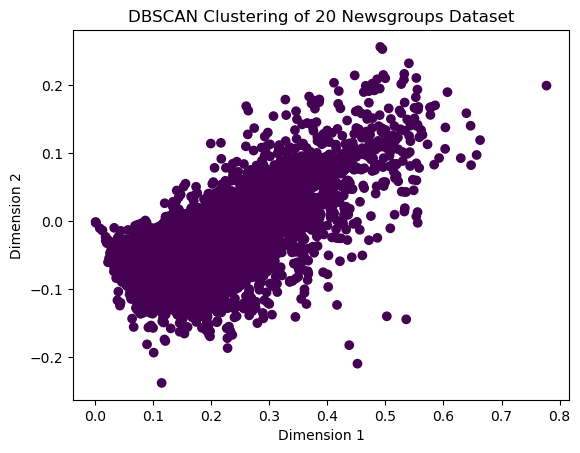

Number of clusters: 0
Number of noise points: 3769


In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

# Step 1: Preprocessing the data
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med',
              'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

# Step 2: Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.8, stratify=dataset.target, random_state=42)

# Step 3: Applying DBSCAN on the training set
vectorizer = TfidfVectorizer(lowercase=True)  # Convert text to lowercase
X_train_transformed = vectorizer.fit_transform(X_train)
X_train_normalized = normalize(X_train_transformed)

# Step 4: Applying DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=20)
dbscan.fit(X_train_normalized)

labels = dbscan.labels_

# Dimensionality reduction for visualization
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_train_normalized)

# Visualize the clusters
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels)
plt.title('DBSCAN Clustering of 20 Newsgroups Dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Print the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)


## FASHION dataset

c:\Users\twahirwa.h\AppData\Local\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


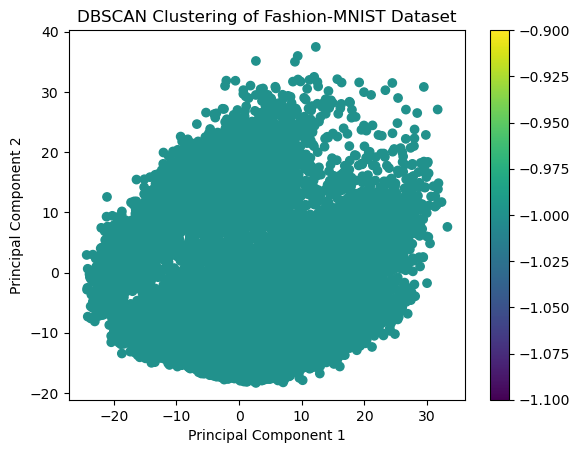

Number of clusters: 0
Number of noise points: 14000


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

# Step 1: Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST')

X_train, X_test, y_train, y_test = train_test_split(fashion_mnist.data, fashion_mnist.target, test_size=0.8, stratify=fashion_mnist.target, random_state=42)

X = X_train
y = y_train

# Step 2: Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_scaled)

labels = dbscan.labels_

# Step 5: Visualize the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('DBSCAN Clustering of Fashion-MNIST Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

# Step 6: Evaluate the clustering results
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)


In [16]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Step 1: Fetching 30% of the 20 Newsgroups dataset
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med',
              'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

data, _, _, _ = train_test_split(dataset.data, dataset.target, test_size=0.7,stratify=dataset.target ,random_state=42)

# Step 2: Preprocessing the data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
X_normalized = normalize(X)

# Step 3: Perform cross-validation grid search
param_grid = {'eps': np.linspace(0.1, 1.0, 10),
              'min_samples': range(1, 20)}

best_score = -1
best_params = None

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_normalized)
        labels = dbscan.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters == 20:  # Check if it creates 20 clusters
            silhouette_avg = silhouette_score(X_normalized, labels)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = {'eps': eps, 'min_samples': min_samples}

# Step 4: Apply DBSCAN with the best parameters
dbscan_best = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_best.fit(X_normalized)

labels = dbscan_best.labels_

# Print the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Best epsilon:", best_params['eps'])
print("Best min_samples:", best_params['min_samples'])
print("Number of clusters:", n_clusters)
print("Number of noise points:", n_noise)
